In [1]:
#Fuentes:
#https://realpython.com/python-keras-text-classification/
#https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

#Embeddings disponibles en:
#https://worksheets.codalab.org/bundles/0x4090ba96b8a444c2a44b2c47884c25f2

#ToDo:
#Limpiar datos de entrada
#Tokenizar, lemmizar con nltk
#K-Fold cross validation
#Grid search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model(XTrain, YTrain, epochs, verbose, validation_data, batch_size):
    history = model.fit(XTrain, YTrain,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=validation_data,
                        batch_size=batch_size)
    loss, accuracy = model.evaluate(XTrain, YTrain, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(validation_data[0], validation_data[1], verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    return history

In [2]:
df_twitter = pd.read_csv('data/train.csv', sep=',')
sentences = df_twitter['text'].values
y = df_twitter['target'].values
df_twitter.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [5]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_dim = 200
#Windows
filename = "embeddings/glove.twitter.27B.200d.txt" 
with open(filename,encoding ="utf8") as my_file:
    text = my_file.read()
embedding_matrix = create_embedding_matrix(text,tokenizer.word_index, embedding_dim)

#iOS
#embedding_matrix = create_embedding_matrix('embeddings/glove.twitter.27B.200d.txt',tokenizer.word_index, embedding_dim)


nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

In [ ]:
filename = "embeddings/glove.twitter.27B.200d.txt" 
with open(filename,encoding ="utf8") as my_file:
    text = my_file.read()
embedding_matrix = create_embedding_matrix(text,tokenizer.word_index, embedding_dim)

In [51]:
model = create_model(num_filters=128,
                     kernel_size=5,
                     vocab_size=vocab_size,
                     embedding_dim=embedding_dim,
                     maxlen=maxlen)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 200)          3703600   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 96, 128)           128128    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 3,833,029
Trainable params: 3,833,029
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9839
Testing Accuracy:  0.7742


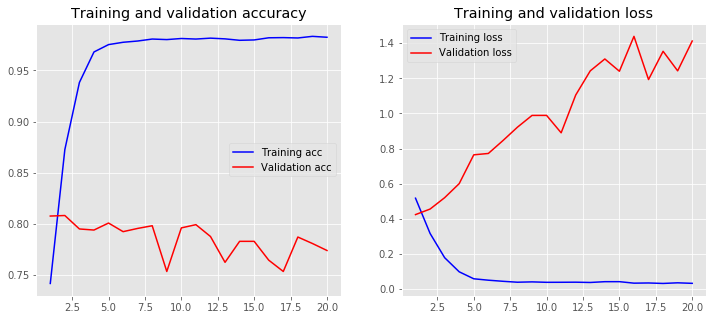

In [52]:
history = train_model(X_train, y_train,
                        epochs=20,
                        verbose=False,
                        validation_data=(X_test, y_test),
                        batch_size=10)

plot_history(history)

In [53]:
df_submit = pd.read_csv('data/test.csv')
df_submit['target'] = 0
df_submit.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0


In [66]:
sentences_predict = df_submit['text'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_predict)
X_predict = tokenizer.texts_to_sequences(sentences_predict)
X_predict = pad_sequences(X_predict, padding='post', maxlen=maxlen)

y_predict = model.predict_classes(X_predict)

In [67]:
kaggle_submission = pd.DataFrame(df_submit,columns = ['id'])
kaggle_submission["target"] = y_predict
kaggle_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [68]:
kaggle_submission.to_csv("data/submits/submission_CNN_02.csv", index=False)